Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/deployment/production-deploy-to-aks/production-deploy-to-aks.png)

# Deploying a web service to Azure Kubernetes Service (AKS)
This notebook shows the steps for deploying a service: registering a model, creating an image, provisioning a cluster (one time action), and deploying a service to it. 
We then test and delete the service, image and model.

In [4]:
from azureml.core import Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.model import Model

In [5]:
import azureml.core
print(azureml.core.VERSION)

1.28.0


# Get workspace
Load existing workspace from the config file info.

In [6]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

datamlops
mlops
westeurope
2fadeb06-9775-43ec-a256-ae5922c67d60


# Create the Environment
Create an environment that the model will be deployed with

In [7]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies 

#conda_deps = CondaDependencies.create(conda_packages=['numpy','scikit-learn==0.19.1','scipy'], pip_packages=['azureml-defaults', 'inference-schema'])
#myenv = Environment(name='myenv')
#myenv.python.conda_dependencies = conda_deps

myenv = Environment.get(workspace=ws, name="tutorial-env")

#### Use a custom Docker image

You can also specify a custom Docker image to be used as base image if you don't want to use the default base image provided by Azure ML. Please make sure the custom Docker image has Ubuntu >= 16.04, Conda >= 4.5.\* and Python(3.5.\* or 3.6.\*).

Only supported with `python` runtime.
```python
# use an image available in public Container Registry without authentication
myenv.docker.base_image = "mcr.microsoft.com/azureml/o16n-sample-user-base/ubuntu-miniconda"

# or, use an image available in a private Container Registry
myenv.docker.base_image = "myregistry.azurecr.io/mycustomimage:1.0"
myenv.docker.base_image_registry.address = "myregistry.azurecr.io"
myenv.docker.base_image_registry.username = "username"
myenv.docker.base_image_registry.password = "password"
```

# Write the Entry Script
Write the script that will be used to predict on your model

In [5]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    try:
        data = np.array(json.loads(raw_data)['data'])
        # make prediction
        y_hat = model.predict(data)
        # you can return any data type as long as it is JSON-serializable
        return y_hat.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


# Create the InferenceConfig
Create the inference config that will be used when deploying the model

In [8]:
from azureml.core.model import InferenceConfig

inf_config = InferenceConfig(entry_script='score.py', environment=myenv)

# Provision the AKS Cluster
This is a one time setup. You can reuse this cluster for multiple deployments after it has been created. If you delete the cluster or the resource group that contains it, then you would have to recreate it.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

In [9]:
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your AKS cluster
#aks_name = 'my-aks-9' 
aks_name = "kube-infer"

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # Use the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()

    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws, 
                                    name = aks_name, 
                                    provisioning_configuration = prov_config)

if aks_target.get_status() != "Succeeded":
    aks_target.wait_for_completion(show_output=True)

Found existing cluster, use it.


# Create AKS Cluster in an existing virtual network (optional)
See code snippet below. Check the documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-enable-virtual-network#use-azure-kubernetes-service) for more details.

In [ ]:
# from azureml.core.compute import ComputeTarget, AksCompute

# # Create the compute configuration and set virtual network information
# config = AksCompute.provisioning_configuration(location="eastus2")
# config.vnet_resourcegroup_name = "mygroup"
# config.vnet_name = "mynetwork"
# config.subnet_name = "default"
# config.service_cidr = "10.0.0.0/16"
# config.dns_service_ip = "10.0.0.10"
# config.docker_bridge_cidr = "172.17.0.1/16"

# # Create the compute target
# aks_target = ComputeTarget.create(workspace = ws,
#                                   name = "myaks",
#                                   provisioning_configuration = config)

# Enable SSL on the AKS Cluster (optional)
See code snippet below. Check the documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-secure-web-service) for more details

In [ ]:
# provisioning_config = AksCompute.provisioning_configuration(ssl_cert_pem_file="cert.pem", ssl_key_pem_file="key.pem", ssl_cname="www.contoso.com")

In [ ]:
#%%time
#aks_target.wait_for_completion(show_output = True)
#print(aks_target.provisioning_state)
#print(aks_target.provisioning_errors)

## Optional step: Attach existing AKS cluster

If you have existing AKS cluster in your Azure subscription, you can attach it to the Workspace.

In [ ]:
# # Use the default configuration (can also provide parameters to customize)
# resource_id = '/subscriptions/92c76a2f-0e1c-4216-b65e-abf7a3f34c1e/resourcegroups/raymondsdk0604/providers/Microsoft.ContainerService/managedClusters/my-aks-0605d37425356b7d01'

# create_name='my-existing-aks' 
# # Create the cluster
# attach_config = AksCompute.attach_configuration(resource_id=resource_id)
# aks_target = ComputeTarget.attach(workspace=ws, name=create_name, attach_configuration=attach_config)
# # Wait for the operation to complete
# aks_target.wait_for_completion(True)

# Deploy web service to AKS

In [10]:
# Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration()

# # Enable token auth and disable (key) auth on the webservice
# aks_config = AksWebservice.deploy_configuration(token_auth_enabled=True, auth_enabled=False)


In [11]:
%%time
model = Model(ws, 'sklearn_mnist')
aks_service_name ='aks-service-1'

aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inf_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-21 16:17:11+00:00 Creating Container Registry if not exists.
2021-06-21 16:17:11+00:00 Registering the environment.
2021-06-21 16:17:11+00:00 Use the existing image..
2021-06-21 16:17:13+00:00 Creating resources in AKS.
2021-06-21 16:17:14+00:00 Submitting deployment to compute.
2021-06-21 16:17:14+00:00 Checking the status of deployment aks-service-1.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 474 ms, sys: 61.8 ms, total: 535 ms
Wall time: 45.2 s


# Test the web service using run method
We test the web sevice by passing data.
Run() method retrieves API keys behind the scenes to make sure that call is authenticated.

## Load test data
Load the test data from the ./data/ directory created during the training tutorial.

In [12]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

## Predict test data
Feed the test dataset to the model to get predictions.

The following code goes through these steps:

Send the data as a JSON array to the web service hosted in ACI.

Use the SDK's run API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [13]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = aks_service.run(input_data=test)

## Examine the confusion matrix
Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the mis-classified value for the incorrect predictions.


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


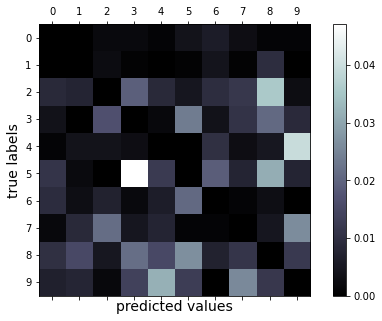

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

## Show predictions
Test the deployed model with a random sample of 30 images from the test data.

Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

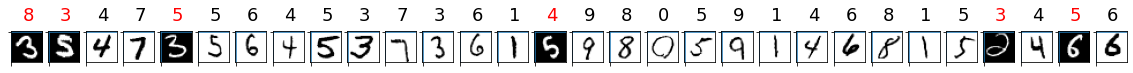

In [28]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = aks_service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

# Test the web service using raw HTTP request (optional)
Alternatively you can construct a raw HTTP request and send it to the service. In this case you need to explicitly pass the HTTP header. This process is shown in the next 2 cells.

In [17]:
# # if (key) auth is enabled, retrieve the API keys. AML generates two keys.
key1, Key2 = aks_service.get_keys()
print(key1)

# # if token auth is enabled, retrieve the token.
#access_token, refresh_after = aks_service.get_token()

QpDAVcjfzz9xR3EPZ1uvhuCPMPobdd13


In [20]:
# construct raw HTTP request and send to the service
#%%time
import requests

import json

# # If (key) auth is enabled, don't forget to add key to the HTTP header.
headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

# # If token auth is enabled, don't forget to add token to the HTTP header.
# headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + access_token}

resp = requests.post(aks_service.scoring_uri, test, headers=headers)


print("prediction:", resp.text)

prediction: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 3, 0, 5, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 7, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 8, 8, 7, 2, 5, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 9, 4, 3, 3, 0, 0, 5, 1, 9, 6, 5, 3, 5, 7, 7, 9, 3, 0, 4, 2, 0, 7, 

# Clean up
Delete the service, image and model.

In [ ]:
%%time
aks_service.delete()
model.delete()